🎯 Objectif
 Construire, visualiser, évaluer et comparer un Arbre de Décision et une Random Forest à partir du dataset
 Titanic.

 🔹 Partie 1 – Chargement & Exploration

In [35]:
import pandas as pd

df = pd.read_csv('Titanic-Dataset.csv')
print(df.head(5))

print("\nTypes données:")
print(df.dtypes)
#df.info()

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  

T

In [34]:
total_passagers = len(df)
nb_survivants = df['Survived'].sum()
proportion_survivants = nb_survivants/total_passagers *100
print(f"nb survivants : {nb_survivants} \nnb total passagers : {total_passagers} \nProportion de survivants : {proportion_survivants:.2f}%")

nb survivants : 342 
nb total passagers : 891 
Proportion de survivants : 38.38%


In [30]:
nb_val_manquante = df.isnull().sum()
pourcentages = (nb_val_manquante / total_passagers) * 100
manquantes = pd.DataFrame({
    'nb_val_manquante': nb_val_manquante,
    '%': pourcentages
})
manquantes = manquantes[manquantes['nb_val_manquante']>0]
print(manquantes)

          nb_val_manquante          %
Age                    177  19.865320
Cabin                  687  77.104377
Embarked                 2   0.224467


� Partie 2 – Nettoyage & Préparation

In [44]:
age_median = df['Age'].median()
df['Age'].fillna(age_median)

most_frequent_embarked = df['Embarked'].mode()[0]
df['Embarked'].fillna(most_frequent_embarked)

print(df.isnull().sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


In [ ]:
df.drop(['PassengerId','Name','Ticket','Cabin'], axis=1, inplace=True)

PassengerId :
→ C’est juste un identifiant unique. Il n’a aucun lien avec la survie ou d’autres caractéristiques utiles pour l’analyse ou la prédiction.
Name :
→ Trop spécifique. Chaque nom est unique ou presque, donc il n’apporte pas directement de valeur en l'état.
Ticket :
→ Numéro très hétérogène, souvent non structuré. Pas vraiment utile sans traitement spécifique.
Cabin :
→ Contient trop de valeurs manquantes (beaucoup de NaN), donc difficile à exploiter efficacement.


In [53]:
df_original = pd.read_csv('Titanic-Dataset.csv')
df['Title'] = df_original['Name'].str.extract(r'([A-Za-z]+)\.', expand=False)
print(df['Title'].unique())


['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']


🎯 Est-ce que Title est informatif ?
Oui ✅ ! Parce qu’il résume le statut social, l’âge ou le genre :

Master → jeune garçon

Miss, Mrs → femme (célibataire/mariée)

Dr, Rev, Col, etc. → statuts sociaux plus rares

Il peut aussi refléter des inégalités face à la survie

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64


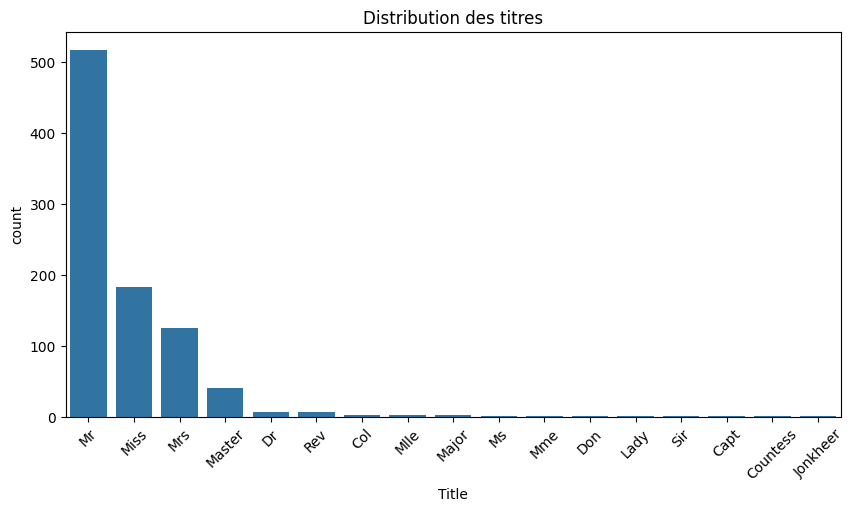

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

print(df['Title'].value_counts())

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Title', order=df['Title'].value_counts().index)
plt.title("Distribution des titres")
plt.xticks(rotation=45)
plt.show()


🎯 Pourquoi regrouper/fusionner certains titres ?
Certains titres sont très rares : ex. 'Countess', 'Jonkheer', 'Don', etc. → leur fréquence est trop faible pour apprendre quelque chose de fiable.

Certains titres veulent dire la même chose :

'Mme' est équivalent à 'Mrs'

'Mlle' et 'Ms' sont proches de 'Miss'

'Dr', 'Rev', 'Major', 'Col', 'Capt', 'Sir', 'Lady' peuvent être regroupés comme "Rare"

In [57]:
df['Title'] = df['Title'].replace({
    'Mlle': 'Miss',
    'Ms': 'Miss',
    'Mme': 'Mrs',
    'Dr': 'Rare',
    'Rev': 'Rare',
    'Major': 'Rare',
    'Col': 'Rare',
    'Capt': 'Rare',
    'Sir': 'Rare',
    'Lady': 'Rare',
    'Don': 'Rare',
    'Countess': 'Rare',
    'Jonkheer': 'Rare'
})

print(df['Title'].value_counts())


Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64


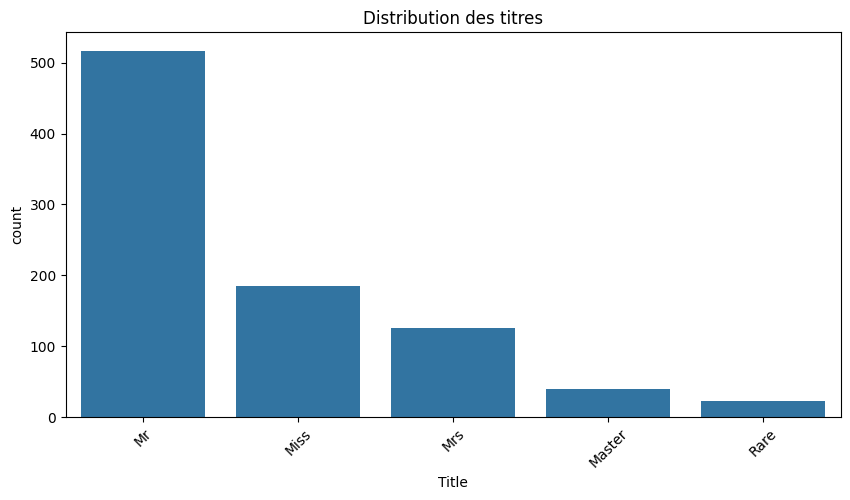

In [58]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Title', order=df['Title'].value_counts().index)
plt.title("Distribution des titres")
plt.xticks(rotation=45)
plt.show()

 🔹 Partie 3 – Encodage & Prétraitement

In [61]:
df['Sex'].unique()
df['Embarked'].unique()
df['Title'].unique()



array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare'], dtype=object)

In [ ]:
# Label Encoding pour Sex
from sklearn.preprocessing import LabelEncoder

le_sex = LabelEncoder()
df['Sex'] = le_sex.fit_transform(df['Sex'])

# OneHot Encoding pour Embarked et Title
df = pd.get_dummies(df, columns=['Embarked', 'Title'], drop_first=True)

# Convertir les colonnes booléennes en int
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

df.head()
#df.dtypes



,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,3,1,22.0,1,0,7.2500,0,1,0,1,0,0
1,1,1,0,38.0,1,0,71.2833,0,0,0,0,1,0
2,1,3,0,26.0,0,0,7.9250,0,1,1,0,0,0
3,1,1,0,35.0,1,0,53.1000,0,1,0,0,1,0
4,0,3,1,35.0,0,0,8.0500,0,1,0,1,0,0


STANDARDISATION:
Pourquoi faire ça ?
Même si les arbres de décision et Random Forests ne sont pas sensibles à l’échelle des variables (car ils ne font pas de calculs de distance), il peut être utile de standardiser dans certains cas :

✅ Raisons de standardiser :
Comparer les variables ou les visualiser sur la même échelle.

Travailler avec d'autres modèles plus tard (comme KNN, SVM, Régression...), qui eux sont sensibles à l’échelle.

Optimiser l’apprentissage dans des pipelines contenant des étapes combinées (ex : PCA, clustering...).

Certaines implémentations (ex : avec sklearn) fonctionnent mieux ou plus vite si les données sont centrées.

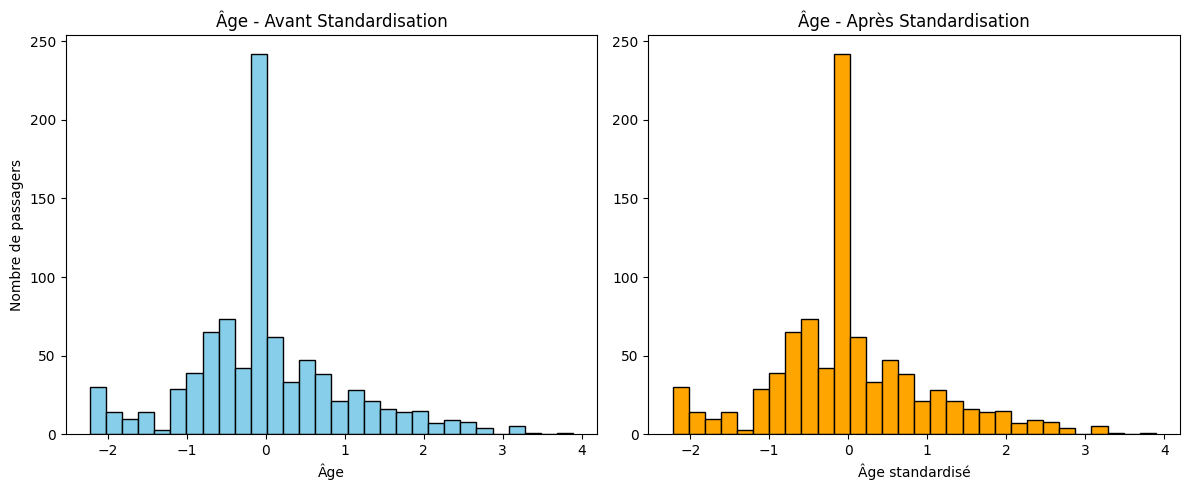

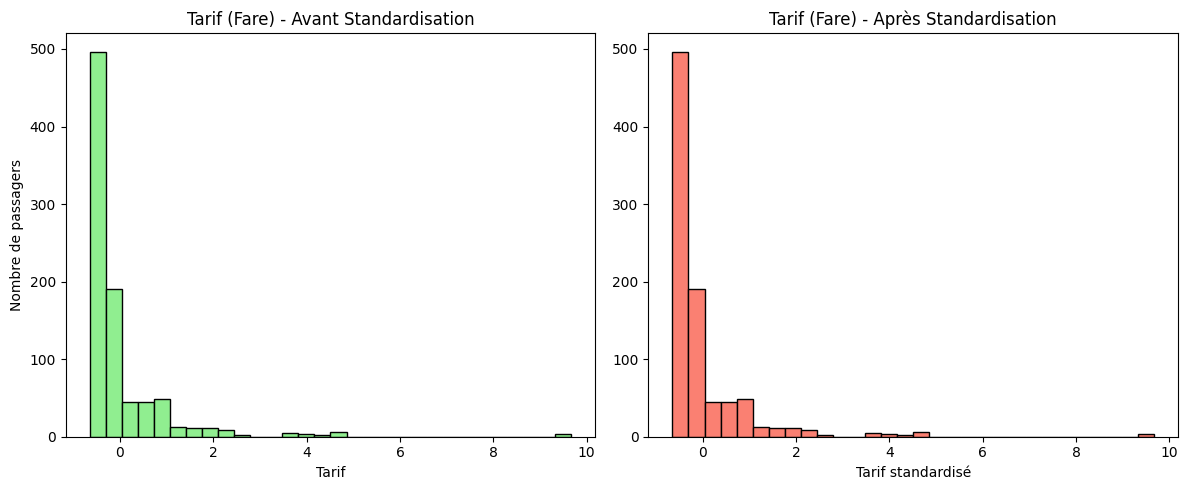

In [ ]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

age_original = df['Age'].copy()
fare_original = df['Fare'].copy()

scaler = StandardScaler()
df[['Age', 'Fare']] = scaler.fit_transform(df[['Age', 'Fare']])

# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.hist(age_original, bins=30, color='skyblue', edgecolor='black')
# plt.title('Âge - Avant Standardisation')
# plt.xlabel('Âge')
# plt.ylabel('Nombre de passagers')

# plt.subplot(1, 2, 2)
# plt.hist(df['Age'], bins=30, color='orange', edgecolor='black')
# plt.title('Âge - Après Standardisation')
# plt.xlabel('Âge standardisé')

# plt.tight_layout()
# plt.show()

# # pour Fare
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.hist(fare_original, bins=30, color='lightgreen', edgecolor='black')
# plt.title('Tarif (Fare) - Avant Standardisation')
# plt.xlabel('Tarif')
# plt.ylabel('Nombre de passagers')

# plt.subplot(1, 2, 2)
# plt.hist(df['Fare'], bins=30, color='salmon', edgecolor='black')
# plt.title('Tarif (Fare) - Après Standardisation')
# plt.xlabel('Tarif standardisé')

# plt.tight_layout()
# plt.show()

🔹 Étape 9 – Division en X et y

In [ ]:
from sklearn.model_selection import train_test_split

#print(df.head())
X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# trained_columns = X_train.columns.tolist()
# print(trained_columns)


['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']
